In [1]:
#importing libraries 
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import skbio
import skbio.diversity
import skbio.stats.composition
import scipy
import pylab as pl
import statsmodels.api as sm
# import statsmodels as sm
from statsmodels.formula.api import ols
from functools import reduce
from scipy import stats


from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import model_selection
from string import ascii_letters
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold



%matplotlib inline

import arivale_data_interface as adi
# apply settings so the lib knows where the data is
adi.apply_isb_config()

#list the local snapshots
local_snapshots = adi.list_local_snapshots()
print(len(local_snapshots))
local_snapshots[0]

# ignore deprecation warnings
import warnings
warnings.filterwarnings('ignore')

98


/users/epepper/miniconda3/envs/micom/lib/python3.7/site-packages/arivale_data_interface/snapshots_interface.py:31: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  DEPRECATIONS = yaml.load(in_yaml)


In [2]:
converters={'public_client_id': lambda x: str(x)}

baseline_metabolomics_corrected = pd.read_csv('baseline_metabolomics_normalized.csv', converters={'public_client_id': lambda x: str(x)})
baseline_metabolomics_corrected = baseline_metabolomics_corrected.drop(['Unnamed: 0'], axis=1)
print('baseline metabolomics corrected:', type(baseline_metabolomics_corrected), baseline_metabolomics_corrected.shape)

hba1c_metrics = pd.read_csv('hba1c_metrics.csv')
hba1c_metrics = hba1c_metrics.drop(['Unnamed: 0'], axis=1)
print('hba1c metrics:', type(hba1c_metrics), hba1c_metrics.shape)

vendor_change = pd.read_csv('vendor_change.csv', converters={'public_client_id': lambda x: str(x)})
vendor_change = vendor_change.drop(['Unnamed: 0'], axis=1)
print('vendor change:', type(vendor_change), vendor_change.shape)

baseline metabolomics corrected: <class 'pandas.core.frame.DataFrame'> (2025, 626)
hba1c metrics: <class 'pandas.core.frame.DataFrame'> (546, 34)
vendor change: <class 'pandas.core.frame.DataFrame'> (3069, 6)


In [3]:
vendor_change

,public_client_id,vendor1,t0,vendor2,t1,vendor_change
0,01001467,LCA,0,LCA,6,0
1,01001621,LCA,0,LCA,6,0
2,01002183,Quest,0,LCA,6,1
3,01002471,LCA,0,LCA,6,0
4,01002885,LCA,0,LCA,6,0
...,...,...,...,...,...,...
3064,01997909,Quest,0,LCA,6,1
3065,01997940,LCA,0,LCA,6,0
3066,01998370,LCA,0,LCA,6,0
3067,01998999,LCA,0,LCA,6,0


In [4]:
metabs = baseline_metabolomics_corrected.copy(deep=True)
metabs = metabs.drop(['sample_id', 'days_in_program', 'days_since_first_call', 
                      'days_since_first_draw', 'month', 'weekday', 'season', 'BATCH_DATE'], axis=1)

resids = hba1c_metrics.copy(deep=True)
resids = resids.drop(['genome_id', 'genome_vendor', 'multiple_genome_ids', 'client_id', 
                      'user_id', 'sex', 'race', 'has_research_consent', 'enterprise', 
                      'coach', 'region', 'country', 'current_program', 'latest_program', 
                      'is_helix', 'age', 'vendor_observation_id', 'days_in_program', 'days_since_first_call', 
                      'BL_time_point', 'month', 'weekday', 'id', 'meds_antibiotics_last_3_months', 
                      'days_since_first_draw_abs', 'BL_hba1c', '2nd_time_point', '2nd_hba1c', 
                      'Raw Delta_hba1c', 'Delta_hba1c', 'Normalized Delta_hba1c', 'Cont_Residuals'], axis=1)

vendor = vendor_change.copy(deep=True)
vendor = vendor.drop(['vendor1', 't0', 'vendor2', 't1'], axis=1)
    
sample_data = pd.merge(resids, metabs, how='inner', on='public_client_id')
hba1c_v_baseline_meta = pd.merge(sample_data, vendor, how='inner', on='public_client_id')
hba1c_v_baseline_meta = hba1c_v_baseline_meta.drop_duplicates()

# column_names = []
# for col in hba1c_v_baseline_meta.iloc[:, 2:618]:
#     column_names.append(col)

# hba1c_v_baseline_meta_filtered = pd.DataFrame()
# # for x in column_names:
# indexNames = hba1c_v_baseline_meta[hba1c_v_baseline_meta[column_names].abs() >= 10].index
# hba1c_v_baseline_meta_filtered = hba1c_v_baseline_meta.drop([indexNames], inplace=True)

# hba1c_v_baseline_meta_filtered.shape
hba1c_v_baseline_meta

,public_client_id,hba1c_Residuals,"Nicotinate and Nicotinamide Metabolism, Cofactors and Vitamins, 1-methylnicotinamide","TCA Cycle, Energy, alpha-ketoglutarate","Tryptophan Metabolism, Amino Acid, kynurenate","Leucine, Isoleucine and Valine Metabolism, Amino Acid, 3-hydroxyisobutyrate","Mevalonate Metabolism, Lipid, 3-hydroxy-3-methylglutarate","Primary Bile Acid Metabolism, Lipid, cholate","Pyrimidine Metabolism, Thymine containing, Nucleotide, 5,6-dihydrothymine","Purine Metabolism, (Hypo)Xanthine/Inosine containing, Nucleotide, hypoxanthine",...,"Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H18N2O4 (2)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H18N2O4 (3)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H20N2O5 (1)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H20N2O5 (2)**","Corticosteroids, Lipid, tetrahydrocortisol glucuronide","Modified Peptides, Peptide, N,N-dimethyl-pro-pro","Chemical, Xenobiotics, oxindolylalanine","Corticosteroids, Lipid, tetrahydrocortisone glucuronide (5)",batch_number,vendor_change
0,01003758,-0.795221,0.619404,0.033193,-0.384671,-0.104918,0.069067,-0.479723,-0.197555,-0.717127,...,-0.202620,-0.140154,0.060765,-13.934652,-0.933010,-0.073019,-0.160603,-0.332095,7,0
2,01004596,0.220044,-0.216364,0.152193,-0.141622,-0.584194,-0.281980,-0.340184,0.260396,0.684512,...,-0.127825,-0.043133,-0.414576,-0.388783,0.328372,-0.005976,-0.383341,0.255494,4,0
4,01005890,0.995236,-0.321529,0.202052,-0.136483,-0.423974,0.056374,-13.587134,0.282395,0.656834,...,0.179740,0.087234,-13.604529,0.314261,0.665525,0.080632,0.091114,0.836284,1,0
5,01006974,0.658996,0.441196,-1.147034,0.037162,0.115608,0.130152,-1.185605,0.481651,0.402017,...,0.359318,0.463525,0.716482,0.659221,-0.067784,0.097910,0.218152,0.003351,0,1
6,01008097,0.288319,0.135011,0.211406,-0.032603,0.010335,-0.113615,1.764850,0.205346,0.566081,...,-0.080720,-0.048325,-0.547817,-0.791387,0.298448,0.153660,0.117121,0.421131,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,01982074,2.591682,0.209868,-0.114664,-0.271821,1.309252,-0.728903,-0.920249,-0.223969,0.232609,...,0.087395,0.094959,0.317939,0.398910,-0.821672,-13.774921,-0.660418,-0.286723,4,0
572,01982352,0.162129,-13.784046,-0.123969,0.527527,0.291252,0.202671,-0.119225,-13.799474,0.240136,...,0.161542,0.106358,-0.485874,-0.363074,0.927196,0.380191,-13.799703,0.904477,6,0
574,01986408,0.162129,0.143763,0.403409,-0.129942,-0.022707,-0.179807,2.761761,0.134131,0.472960,...,-13.770746,-0.121461,-0.848469,-0.762370,-0.220012,-13.781829,-0.323679,-0.584741,8,0
575,01994330,0.683958,0.115578,0.283981,0.787140,0.977518,0.104496,-13.818670,0.003431,0.612292,...,-0.479585,-0.402289,-0.724480,-0.856731,0.029904,0.488053,-0.477837,0.378299,0,1


In [5]:
deltas_metabolomics_normalized = hba1c_v_baseline_meta.copy(deep=True)

deltas_metabolomics_normalized.set_index('public_client_id',inplace=True)
deltas_metabolomics_normalized.index=deltas_metabolomics_normalized.index.astype('str')
deltas_metabolomics_normalized.shape

(423, 619)

In [6]:
#Scale and standardize omics (columns 0-last relevant column)
X = deltas_metabolomics_normalized[deltas_metabolomics_normalized.columns[1:617]]
#define the dependent variable (normalized deltas)
y = (deltas_metabolomics_normalized['hba1c_Residuals'])
#scale and standardize
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
Xcolumns=X.columns
X = scaler.fit_transform(X)
X=pd.DataFrame(data=X,columns=Xcolumns)
X

,"Nicotinate and Nicotinamide Metabolism, Cofactors and Vitamins, 1-methylnicotinamide","TCA Cycle, Energy, alpha-ketoglutarate","Tryptophan Metabolism, Amino Acid, kynurenate","Leucine, Isoleucine and Valine Metabolism, Amino Acid, 3-hydroxyisobutyrate","Mevalonate Metabolism, Lipid, 3-hydroxy-3-methylglutarate","Primary Bile Acid Metabolism, Lipid, cholate","Pyrimidine Metabolism, Thymine containing, Nucleotide, 5,6-dihydrothymine","Purine Metabolism, (Hypo)Xanthine/Inosine containing, Nucleotide, hypoxanthine","Polyunsaturated Fatty Acid (n3 and n6), Lipid, linoleate (18:2n6)","Medium Chain Fatty Acid, Lipid, laurate (12:0)",...,"Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C16H18N2O5 (2)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H18N2O4 (1)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H18N2O4 (2)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H18N2O4 (3)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H20N2O5 (1)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H20N2O5 (2)**","Corticosteroids, Lipid, tetrahydrocortisol glucuronide","Modified Peptides, Peptide, N,N-dimethyl-pro-pro","Chemical, Xenobiotics, oxindolylalanine","Corticosteroids, Lipid, tetrahydrocortisone glucuronide (5)"
0,0.425128,0.187212,0.053119,0.080254,0.218187,0.107043,0.087804,-0.229716,0.483028,0.436646,...,0.159874,0.195058,0.138188,0.092905,0.225639,-5.832182,-0.065268,0.162290,0.212311,0.099719
1,0.092981,0.231878,0.141940,-0.131725,0.089398,0.140797,0.279072,0.452818,0.456561,0.185814,...,0.036971,0.120844,0.162721,0.132711,0.069177,-0.018174,0.342506,0.187641,0.144113,0.302286
2,0.051187,0.250592,0.143818,-0.060861,0.213530,-3.063576,0.288260,0.439340,0.021862,0.702859,...,0.170959,0.252767,0.263603,0.186197,-4.272397,0.283579,0.451499,0.220391,0.289382,0.502510
3,0.354305,-0.255781,0.207276,0.177790,0.240598,-0.063706,0.371482,0.315256,-0.100235,-0.109374,...,0.325712,0.269093,0.322506,0.340580,0.441473,0.431639,0.214438,0.226925,0.328278,0.215362
4,0.232623,0.254103,0.181780,0.131229,0.151166,0.649995,0.256080,0.395147,-0.051635,-0.149379,...,0.116205,0.198162,0.178172,0.130581,0.025319,-0.190976,0.332832,0.248006,0.297344,0.359388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,0.262372,0.131714,0.094360,0.705727,-0.074565,0.000482,0.076772,0.232762,0.219849,0.210391,...,0.254272,0.288168,0.233314,0.189366,0.310289,0.319911,-0.029275,-5.018987,0.059278,0.115360
419,-5.299008,0.128222,0.386477,0.255476,0.267203,0.194246,-5.593190,0.236427,0.172977,0.156418,...,-5.230623,0.245576,0.257634,0.194043,0.045709,-0.007140,0.536091,0.333668,-3.963702,0.526019
420,0.236101,0.326171,0.146208,0.116615,0.126883,0.891143,0.226336,0.349802,0.247087,0.244017,...,-5.311022,0.177609,-4.312202,0.100575,-0.073643,-0.178521,0.165226,-5.021599,0.162381,0.012621
421,0.224900,0.281344,0.481352,0.559004,0.231185,-3.119583,0.171748,0.417650,0.203646,0.356751,...,-0.038054,0.093784,0.047343,-0.014642,-0.032831,-0.219021,0.246018,0.374455,0.115180,0.344622


In [7]:
## run cross_val_score on ridge and lasso to get out-of-sample R2 scores across 10-CV
#This is pretty much the sklearn version doing what my code is doing in the cell below.
#defining L2 parameters to be tested
alphas = np.linspace(1,1000,200)

#Defining LASSO and Ridge parameters
#alphas are the tuning parameters tested by the algorithm, epse is a ratio of the lowest to highest alpha, provding
#a range for where the algorithm should focus the search
#Since the dependent variable was not scaled and standardized we also fit an intercept
lassocv=LassoCV(eps=0.25, n_alphas=200, alphas=None, fit_intercept=False, normalize=False, precompute='auto', cv=10)
ridgecv=RidgeCV(alphas=alphas,fit_intercept=True,normalize=False,cv=10)

#Running 10-fold CV score function to get mean out-of-sample R2
# discovery_score = cross_val_score(lassocv,X,y,cv=10)
# print ('mean out-of-sample R2 LASSO',np.mean(discovery_score))
# discovery_score_ridge = cross_val_score(ridgecv,X,y,cv=10)
# print ('mean out-of-sample R2 Ridge',np.mean(discovery_score_ridge))

In [8]:
#Run Cross-validation and extract Beta_coefficients for each model
#this is pretty much replicating the analysis above, but extracting different variables along the way
#Save predictions from each test set
lassocv=LassoCV(eps=0.25, n_alphas=200, alphas=None, fit_intercept=False, normalize=False, precompute='auto', cv=10)

y=deltas_metabolomics_normalized['hba1c_Residuals']
y=y.reset_index()
y.drop(['public_client_id'],1,inplace=True)

#split data into ten sets
X_folds = np.array_split(X, 10)
y_folds = np.array_split(y, 10)

#create a dataframe here coefficients for each metric will be stored
coefficients=pd.DataFrame(index=X.columns).astype('str')

#lists for other variables extracted from the 10-fold CV
predictions=[]
alphas= []
score= []

#perform the 10-fold CV scheme to predict the normalized deltas
for k in range(10):
    X_train = list(X_folds)
    X_test  = X_train.pop(k)
    X_train = np.concatenate(X_train)
    y_train = list(y_folds)
    y_test  = y_train.pop(k)
    y_test=[ x[0] for x in  list(y_test.values)]
    y_train = np.concatenate(y_train)
    lassocv.fit(X_train, y_train)
    predictions.append(lassocv.predict(X_test).flatten())
    coef=list(lassocv.coef_)
    coefficients[k]=coef
    alphas.append(lassocv.alpha_)
    score.append(r2_score(y_test,lassocv.predict(X_test)))
    
#print The L1 penalty for each model
print (alphas)
predictions_lasso=[item for sublist in predictions for item in sublist]

#Checking r2 score and pearson r
print ('mean R2 Score LASSO',np.mean(score))
print ('std. deviation for R2 Score',np.std(score))
print ('S.E.M',np.std(score)/np.sqrt(10))
print ('observed v predicted pearson r',stats.pearsonr(deltas_metabolomics_normalized['hba1c_Residuals'],predictions_lasso))

[0.06206002193297486, 0.0555264803473662, 0.08359539234624015, 0.08800405697279262, 0.08823783508842738, 0.057034472262770836, 0.08051915270391112, 0.06230867314817198, 0.061912804469385324, 0.06816927538181004]
mean R2 Score LASSO 0.05068970758708774
std. deviation for R2 Score 0.15703518146166418
S.E.M 0.04965888461967082
observed v predicted pearson r (0.2809340538703521, 4.110403790676194e-09)


In [9]:
print('metabolome scores are:', score)

metabolome scores are: [0.023445104122709948, -0.3644417277824372, 0.13475790220003547, 0.18484767744008535, 0.03997912415547089, 0.24532829877399664, 0.03326361989145887, 0.12249880209378183, 0.09310106404035545, -0.005882789064579841]


In [10]:
#generate dataframe with out-of-sample predictions for each person
predictions = pd.DataFrame(index = deltas_metabolomics_normalized.index)
predictions['predictions'] = predictions_lasso
predictions['hba1c_Residuals']=deltas_metabolomics_normalized['hba1c_Residuals']

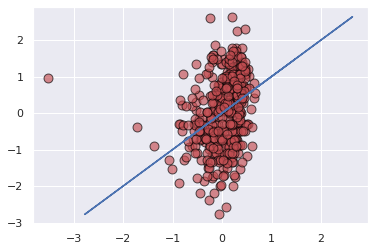

In [11]:
plt.scatter(predictions_lasso, deltas_metabolomics_normalized['hba1c_Residuals'], s=80, color='r', alpha=0.65, linewidth=1, edgecolors='black')
plt.plot(y, y)

In [12]:
#Identifying all features with non-zero Beta Coefficients

for x in coefficients.index.tolist():
    if (coefficients.loc[x] == 0.0).sum()==10:
        coefficients.drop([x],inplace=True)
print (coefficients.shape)
#calculating mean beta-coefficient for each feature and counting no. of times each feature had a 0 beta-coefficient.
means=[]
std=[]
zeroes=[]
for x in coefficients.index.tolist():
    means.append((np.mean(coefficients.loc[x])))
    std.append((np.std(coefficients.loc[x])))
    zeroes.append((coefficients.loc[x] == 0.0).astype(int).sum())
coefficients['mean']=means
coefficients['std_dev']=std
coefficients['zeroes']=zeroes
#save table as csv
coefficients.to_csv('metabolomics_corrected_40_coefs.csv')
coefficients.sort_values(by='mean',ascending=False).head()

(162, 10)


,0,1,2,3,4,5,6,7,8,9,mean,std_dev,zeroes
"Phenylalanine and Tyrosine Metabolism, Amino Acid, N-acetyltyrosine",0.063689,0.102548,0.077860,0.073455,0.064773,0.053711,0.027925,0.102801,0.076371,0.110865,0.075400,0.023939,0
"Phospholipid Metabolism, Lipid, 1-stearoyl-2-docosahexaenoyl-GPC (18:0/22:6)",0.081884,0.089444,0.044092,0.057683,0.060873,0.071879,0.086743,0.088215,0.105374,0.060195,0.074638,0.017814,0
"Purine Metabolism, (Hypo)Xanthine/Inosine containing, Nucleotide, urate",0.048837,0.084812,0.075030,0.069181,0.047411,0.077886,0.063166,0.097008,0.092787,0.086740,0.074286,0.016302,0
"Pentose Metabolism, Carbohydrate, arabonate/xylonate",0.067863,0.088125,0.077969,0.064502,0.081836,0.076390,0.044775,0.098148,0.057948,0.053279,0.071083,0.015651,0
"Monoacylglycerol, Lipid, 1-linoleoylglycerol (18:2)",0.075233,0.049761,0.052568,0.054747,0.057653,0.065450,0.055283,0.062097,0.029331,0.056512,0.055863,0.011239,0


In [13]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

x = deltas_metabolomics_normalized[['Fatty Acid Metabolism (Acyl Carnitine, Hydroxy), Lipid, cis-3,4-methyleneheptanoylcarnitine']]
y = deltas_metabolomics_normalized['hba1c_Residuals']

model_1 = LinearRegression().fit(x, y)
score1 = model_1.score(x, y)
print('34mhc alone:', 'r2 = ', score1, 'coef = ', model_1.coef_, 'intercept = ', model_1.intercept_)


x_cov = deltas_metabolomics_normalized[['Fatty Acid Metabolism (Acyl Carnitine, Hydroxy), Lipid, cis-3,4-methyleneheptanoylcarnitine', 
                                        'vendor_change']]

model_2 = LinearRegression().fit(x_cov, y)
score2 = model_2.score(x_cov, y)
print('34mhc with vendor_change:','r2 = ', score2, 'coef = ', model_2.coef_, 'intercept = ', model_2.intercept_)

x_cov3 = deltas_metabolomics_normalized[['Fatty Acid Metabolism (Acyl Carnitine, Hydroxy), Lipid, cis-3,4-methyleneheptanoylcarnitine', 
                                        'batch_number']]

model_3 = LinearRegression().fit(x_cov3, y)
score3 = model_3.score(x_cov3, y)
print('34mhc with batch_number:','r2 = ', score3, 'coef = ', model_3.coef_, 'intercept = ', model_3.intercept_)

34mhc alone: r2 =  0.03130995399659087 coef =  [0.0702344] intercept =  0.12533518784061615
34mhc with vendor_change: r2 =  0.4138328812005597 coef =  [0.0543998  1.20855805] intercept =  -0.42415457282550584
34mhc with batch_number: r2 =  0.3757828688922237 coef =  [ 0.05323574 -0.2179377 ] intercept =  0.6669169355166281


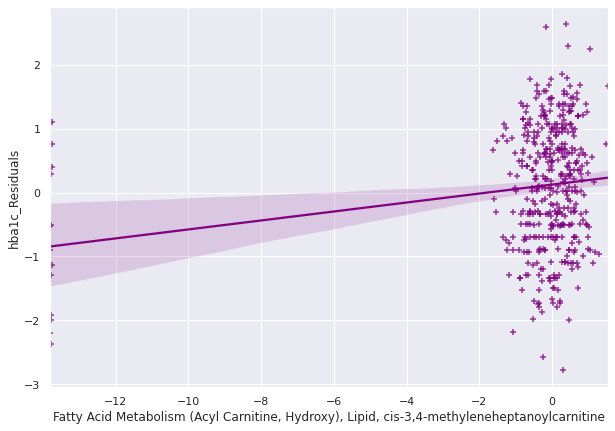

In [14]:
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=deltas_metabolomics_normalized['Fatty Acid Metabolism (Acyl Carnitine, Hydroxy), Lipid, cis-3,4-methyleneheptanoylcarnitine'], 
            y=deltas_metabolomics_normalized['hba1c_Residuals'], color='purple', marker='+')
fig.savefig('cis-3-4-methyleneheptanoylcarnitine_v_hba1c_residuals.png')

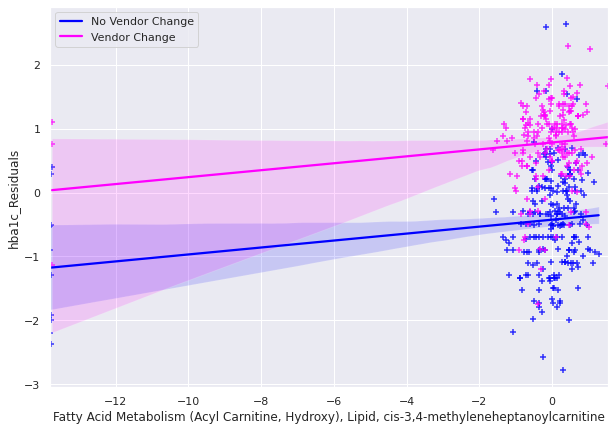

In [15]:
df_no_change = deltas_metabolomics_normalized[deltas_metabolomics_normalized['vendor_change'] == 0]
df_change = deltas_metabolomics_normalized[deltas_metabolomics_normalized['vendor_change'] == 1]

fig = plt.figure(figsize=(10, 7))
sns.regplot(x=df_no_change['Fatty Acid Metabolism (Acyl Carnitine, Hydroxy), Lipid, cis-3,4-methyleneheptanoylcarnitine'], 
            y=df_no_change['hba1c_Residuals'], color='blue', marker='+')
sns.regplot(x=df_change['Fatty Acid Metabolism (Acyl Carnitine, Hydroxy), Lipid, cis-3,4-methyleneheptanoylcarnitine'], 
            y=df_change['hba1c_Residuals'], color='magenta', marker='+')
plt.legend(labels=['No Vendor Change', 'Vendor Change'])
fig.savefig('separated_cis-3-4-methyleneheptanoylcarnitine_v_hba1c_residuals.png')

Index(['01075262', '01165590', '01174518', '01195760', '01218722', '01256739',
       '01360278', '01411965', '01463699', '01522368', '01632380', '01758362',
       '01839338'],
      dtype='object', name='public_client_id')
(423, 619)
(410, 4)


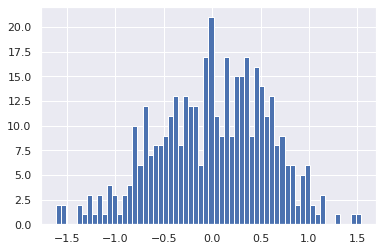

In [16]:
# removing the outliers
mch_v_hba1c = deltas_metabolomics_normalized[['Fatty Acid Metabolism (Acyl Carnitine, Hydroxy), Lipid, cis-3,4-methyleneheptanoylcarnitine', 
                                             'hba1c_Residuals', 'vendor_change', 'batch_number']]

indexNames = mch_v_hba1c[mch_v_hba1c['Fatty Acid Metabolism (Acyl Carnitine, Hydroxy), Lipid, cis-3,4-methyleneheptanoylcarnitine'].abs() >= 12].index
print(indexNames)
mch_v_hba1c.drop(indexNames, inplace=True)
mch_v_hba1c

print(deltas_metabolomics_normalized.shape)
print(mch_v_hba1c.shape)
plt.hist(mch_v_hba1c['Fatty Acid Metabolism (Acyl Carnitine, Hydroxy), Lipid, cis-3,4-methyleneheptanoylcarnitine'], bins=60);

In [17]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

x = mch_v_hba1c[['Fatty Acid Metabolism (Acyl Carnitine, Hydroxy), Lipid, cis-3,4-methyleneheptanoylcarnitine']]
y = mch_v_hba1c['hba1c_Residuals']

model_1 = LinearRegression().fit(x, y)
score1 = model_1.score(x, y)
print('34mhc alone:', 'r2 = ', score1, 'coef = ', model_1.coef_, 'intercept = ', model_1.intercept_)


x_cov = mch_v_hba1c[['Fatty Acid Metabolism (Acyl Carnitine, Hydroxy), Lipid, cis-3,4-methyleneheptanoylcarnitine', 
                                        'vendor_change']]

model_2 = LinearRegression().fit(x_cov, y)
score2 = model_2.score(x_cov, y)
print('34mhc with vendor_change:','r2 = ', score2, 'coef = ', model_2.coef_, 'intercept = ', model_2.intercept_)

x_cov3 = mch_v_hba1c[['Fatty Acid Metabolism (Acyl Carnitine, Hydroxy), Lipid, cis-3,4-methyleneheptanoylcarnitine', 
                                        'batch_number']]

model_3 = LinearRegression().fit(x_cov3, y)
score3 = model_3.score(x_cov3, y)
print('34mhc with batch_number:','r2 = ', score3, 'coef = ', model_3.coef_, 'intercept = ', model_3.intercept_)

34mhc alone: r2 =  0.006517166356182047 coef =  [0.13288354] intercept =  0.12354667154208357
34mhc with vendor_change: r2 =  0.4110117659051097 coef =  [0.1865759  1.21630512] intercept =  -0.4314179417574352
34mhc with batch_number: r2 =  0.3692334172226329 coef =  [ 0.17715233 -0.220067  ] intercept =  0.6687096096694922


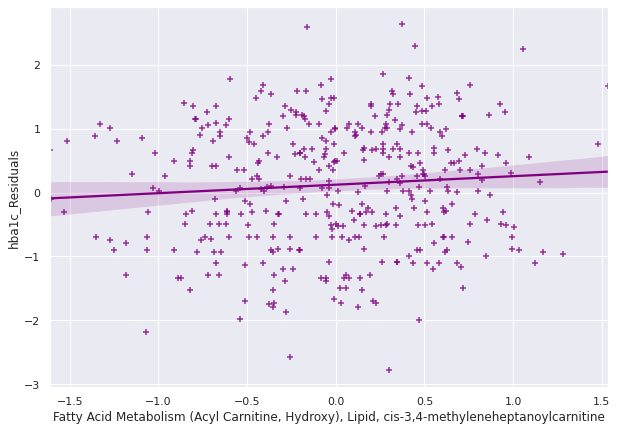

In [18]:
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=mch_v_hba1c['Fatty Acid Metabolism (Acyl Carnitine, Hydroxy), Lipid, cis-3,4-methyleneheptanoylcarnitine'], 
            y=mch_v_hba1c['hba1c_Residuals'], color='purple', marker='+')
fig.savefig('rem_outliers_cis-3-4-methyleneheptanoylcarnitine_v_hba1c_residuals.png')

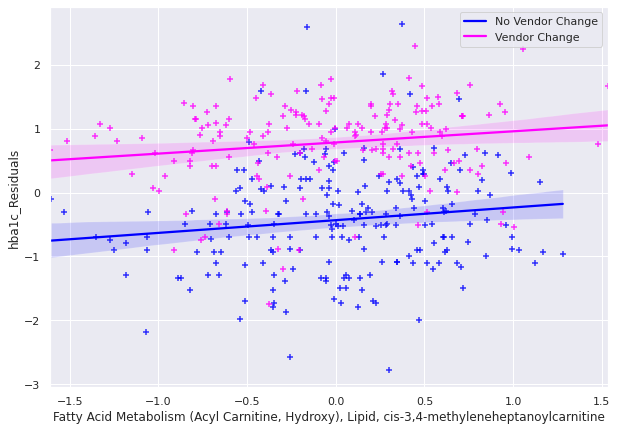

In [19]:
df_no_change = mch_v_hba1c[mch_v_hba1c['vendor_change'] == 0]
df_change = mch_v_hba1c[mch_v_hba1c['vendor_change'] == 1]

fig = plt.figure(figsize=(10, 7))
sns.regplot(x=df_no_change['Fatty Acid Metabolism (Acyl Carnitine, Hydroxy), Lipid, cis-3,4-methyleneheptanoylcarnitine'], 
            y=df_no_change['hba1c_Residuals'], color='blue', marker='+')
sns.regplot(x=df_change['Fatty Acid Metabolism (Acyl Carnitine, Hydroxy), Lipid, cis-3,4-methyleneheptanoylcarnitine'], 
            y=df_change['hba1c_Residuals'], color='magenta', marker='+')
plt.legend(labels=['No Vendor Change', 'Vendor Change'])
fig.savefig('rem_outliers_separated_cis-3-4-methyleneheptanoylcarnitine_v_hba1c_residuals.png')

In [20]:
features = coefficients.index.to_list()
features

selected_metabolites = pd.DataFrame()
for x in features:
    selected_metabolites[x] = deltas_metabolomics_normalized[x]

residual_metadata = resids.copy(deep=True)
residual_metadata = residual_metadata.set_index('public_client_id')


v2_selected_metabolites = pd.merge(selected_metabolites, residual_metadata, left_index=True, right_index=True)
v2_selected_metabolites

,"Nicotinate and Nicotinamide Metabolism, Cofactors and Vitamins, 1-methylnicotinamide","Medium Chain Fatty Acid, Lipid, laurate (12:0)","Nicotinate and Nicotinamide Metabolism, Cofactors and Vitamins, quinolinate","Lysine Metabolism, Amino Acid, N6,N6,N6-trimethyllysine","Methionine, Cysteine, SAM and Taurine Metabolism, Amino Acid, N-formylmethionine","Urea cycle; Arginine and Proline Metabolism, Amino Acid, arginine","Alanine and Aspartate Metabolism, Amino Acid, aspartate","Creatine Metabolism, Amino Acid, creatinine","Gamma-glutamyl Amino Acid, Peptide, gamma-glutamylglutamate","Primary Bile Acid Metabolism, Lipid, glycocholate",...,"Methionine, Cysteine, SAM and Taurine Metabolism, Amino Acid, 2,3-dihydroxy-5-methylthio-4-pentenoate (DMTPA)*","Pregnenolone Steroids, Lipid, pregnenetriol disulfate*","Fatty Acid, Dicarboxylate, Lipid, eicosenedioate (C20:1-DC)*","Lysine Metabolism, Amino Acid, hydroxy-N6,N6,N6-trimethyllysine*","Ceramide PEs, Lipid, palmitoyl-sphingosine-phosphoethanolamine (d18:1/16:0)","Food Component/Plant, Xenobiotics, (S)-a-amino-omega-caprolactam","Fatty Acid, Dicarboxylate, Lipid, branched chain 14:0 dicarboxylic acid**","Fatty Acid Metabolism (Acyl Carnitine, Hydroxy), Lipid, cis-3,4-methyleneheptanoylcarnitine","Corticosteroids, Lipid, tetrahydrocortisone glucuronide (5)",hba1c_Residuals
public_client_id,,,,,,,,,,,,,,,,,,,,,
01003758,0.619404,0.770789,-0.341587,-0.257152,-0.193706,-0.226169,-0.264256,0.152346,-0.496930,-0.985096,...,-0.218245,-0.005457,0.101457,-0.563238,-0.213764,-0.134683,0.392802,-1.180615,-0.332095,-0.795221
01004596,-0.216364,0.113546,-0.347904,-0.018966,0.324257,0.158659,-0.052566,-0.019785,0.246768,-0.209504,...,0.057225,0.291751,-0.165794,0.117527,0.344156,0.024999,-0.605691,0.347905,0.255494,0.220044
01005890,-0.321529,1.468338,-0.385799,0.228610,0.206271,0.276339,0.718916,0.254197,1.053808,-0.776834,...,-13.744708,0.847859,0.448843,0.268426,0.253470,-13.736600,0.497135,-0.004639,0.836284,0.995236
01006974,0.441196,-0.659922,0.008670,-0.214786,0.049907,-0.185228,0.092782,0.053523,0.551435,-2.963878,...,0.078025,0.488322,-0.124282,-0.141019,-0.084284,0.063682,1.896584,0.635405,0.003351,0.658996
01008097,0.135011,-0.764744,0.078117,0.584316,0.008930,-0.157963,0.203777,-13.805732,0.272857,-0.576955,...,0.162292,0.341273,0.132840,0.290531,-0.018728,-13.714010,1.849482,0.499930,0.421131,0.288319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01982074,0.209868,0.177946,-0.839995,-0.686568,-0.192981,-0.302595,-0.921262,-0.128460,-0.196543,-1.238773,...,-0.448340,-0.105287,-0.204953,-0.531872,-0.004959,-0.099056,0.581224,-0.161648,-0.286723,2.591682
01982352,-13.784046,0.036520,-13.800817,0.187777,0.156075,-13.827305,0.183274,0.171163,0.479841,-1.040235,...,0.363978,0.863967,0.283721,-0.046750,-0.233927,0.130512,1.630216,1.150532,0.904477,0.162129
01986408,0.143763,0.266052,0.153996,0.190042,0.018690,-0.087084,-0.380447,-0.112196,-0.433762,0.638303,...,0.122269,0.262698,-0.240516,0.015226,0.197820,0.217866,-0.653009,0.299667,-0.584741,0.162129


In [21]:
# loop through selected features from all omics and perform linear regression for each on against deltas

x = v2_selected_metabolites[['hba1c_Residuals']]

r2 = []

for i in range(v2_selected_metabolites.shape[1] - 2):
    model = LinearRegression().fit(x, v2_selected_metabolites.iloc[:, i+1])
    score = model.score(x, v2_selected_metabolites.iloc[:, i+1])
    
    r2.append(score)

uni_reg_all = pd.DataFrame()
features = list(v2_selected_metabolites.columns.values)

features_series = pd.Series(features[1:len(features) - 1])
r2_series = pd.Series(r2)

uni_reg_all['feature'] = features_series.values
uni_reg_all['r2'] = r2_series.values

uni_reg_all = uni_reg_all.sort_values(by=['r2'], ascending=False)
uni_reg_all.to_csv('hba1c_top_metabolites.csv')
print(uni_reg_all.head(n=10))

total_variance = uni_reg_all['r2'].sum()
print(total_variance)

                                               feature        r2
59   Phenylalanine and Tyrosine Metabolism, Amino A...  0.043968
103   Lysolipid, Lipid, 1-eicosapentaenoyl-GPE (20:5)*  0.041632
57   Monoacylglycerol, Lipid, 1-linoleoylglycerol (...  0.036486
38   Sphingolipid Metabolism, Lipid, N-palmitoyl-sp...  0.035749
110  Pentose Metabolism, Carbohydrate, arabonate/xy...  0.035577
118  Phospholipid Metabolism, Lipid, 1-stearoyl-2-d...  0.035132
123  Plasmalogen, Lipid, 1-(1-enyl-palmitoyl)-2-ara...  0.034307
31   Purine Metabolism, (Hypo)Xanthine/Inosine cont...  0.031856
159  Fatty Acid Metabolism (Acyl Carnitine, Hydroxy...  0.031310
49   Leucine, Isoleucine and Valine Metabolism, Ami...  0.030456
2.3278470357136953


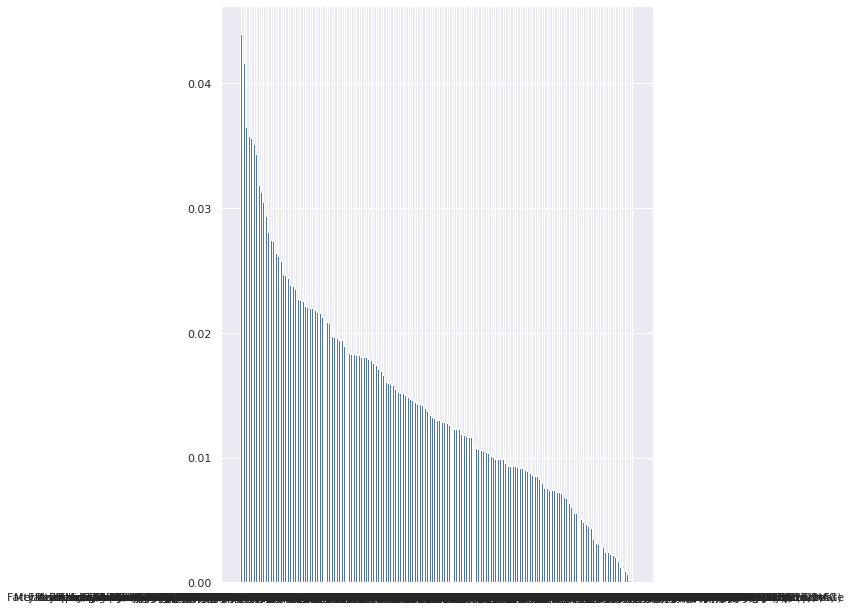

In [22]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,2])

features = uni_reg_all['feature']
r2 = uni_reg_all['r2']

ax.bar(features,r2)
plt.show()

In [23]:
deltas_metabolomics_normalized

,hba1c_Residuals,"Nicotinate and Nicotinamide Metabolism, Cofactors and Vitamins, 1-methylnicotinamide","TCA Cycle, Energy, alpha-ketoglutarate","Tryptophan Metabolism, Amino Acid, kynurenate","Leucine, Isoleucine and Valine Metabolism, Amino Acid, 3-hydroxyisobutyrate","Mevalonate Metabolism, Lipid, 3-hydroxy-3-methylglutarate","Primary Bile Acid Metabolism, Lipid, cholate","Pyrimidine Metabolism, Thymine containing, Nucleotide, 5,6-dihydrothymine","Purine Metabolism, (Hypo)Xanthine/Inosine containing, Nucleotide, hypoxanthine","Polyunsaturated Fatty Acid (n3 and n6), Lipid, linoleate (18:2n6)",...,"Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H18N2O4 (2)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H18N2O4 (3)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H20N2O5 (1)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H20N2O5 (2)**","Corticosteroids, Lipid, tetrahydrocortisol glucuronide","Modified Peptides, Peptide, N,N-dimethyl-pro-pro","Chemical, Xenobiotics, oxindolylalanine","Corticosteroids, Lipid, tetrahydrocortisone glucuronide (5)",batch_number,vendor_change
public_client_id,,,,,,,,,,,,,,,,,,,,,
01003758,-0.795221,0.619404,0.033193,-0.384671,-0.104918,0.069067,-0.479723,-0.197555,-0.717127,0.843247,...,-0.202620,-0.140154,0.060765,-13.934652,-0.933010,-0.073019,-0.160603,-0.332095,7,0
01004596,0.220044,-0.216364,0.152193,-0.141622,-0.584194,-0.281980,-0.340184,0.260396,0.684512,0.781318,...,-0.127825,-0.043133,-0.414576,-0.388783,0.328372,-0.005976,-0.383341,0.255494,4,0
01005890,0.995236,-0.321529,0.202052,-0.136483,-0.423974,0.056374,-13.587134,0.282395,0.656834,-0.235815,...,0.179740,0.087234,-13.604529,0.314261,0.665525,0.080632,0.091114,0.836284,1,0
01006974,0.658996,0.441196,-1.147034,0.037162,0.115608,0.130152,-1.185605,0.481651,0.402017,-0.521505,...,0.359318,0.463525,0.716482,0.659221,-0.067784,0.097910,0.218152,0.003351,0,1
01008097,0.288319,0.135011,0.211406,-0.032603,0.010335,-0.113615,1.764850,0.205346,0.566081,-0.407789,...,-0.080720,-0.048325,-0.547817,-0.791387,0.298448,0.153660,0.117121,0.421131,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01982074,2.591682,0.209868,-0.114664,-0.271821,1.309252,-0.728903,-0.920249,-0.223969,0.232609,0.227445,...,0.087395,0.094959,0.317939,0.398910,-0.821672,-13.774921,-0.660418,-0.286723,4,0
01982352,0.162129,-13.784046,-0.123969,0.527527,0.291252,0.202671,-0.119225,-13.799474,0.240136,0.117772,...,0.161542,0.106358,-0.485874,-0.363074,0.927196,0.380191,-13.799703,0.904477,6,0
01986408,0.162129,0.143763,0.403409,-0.129942,-0.022707,-0.179807,2.761761,0.134131,0.472960,0.291180,...,-13.770746,-0.121461,-0.848469,-0.762370,-0.220012,-13.781829,-0.323679,-0.584741,8,0


<AxesSubplot:xlabel='hba1c_Residuals', ylabel='vendor_change'>

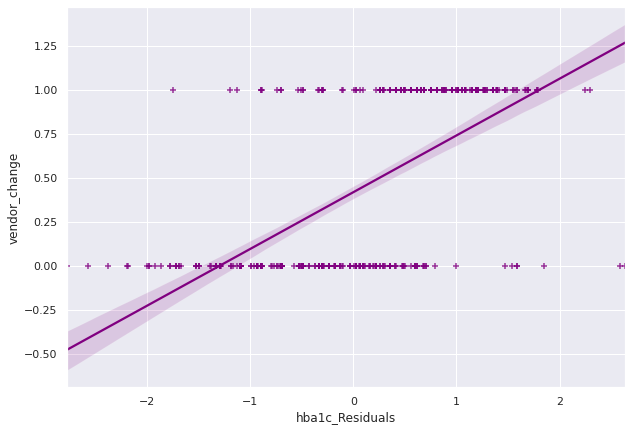

In [25]:
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=deltas_metabolomics_normalized['hba1c_Residuals'], 
            y=deltas_metabolomics_normalized['vendor_change'], color='purple', marker='+')

# fig.savefig('rem_outliers_cis-3-4-methyleneheptanoylcarnitine_v_hba1c_residuals.png')

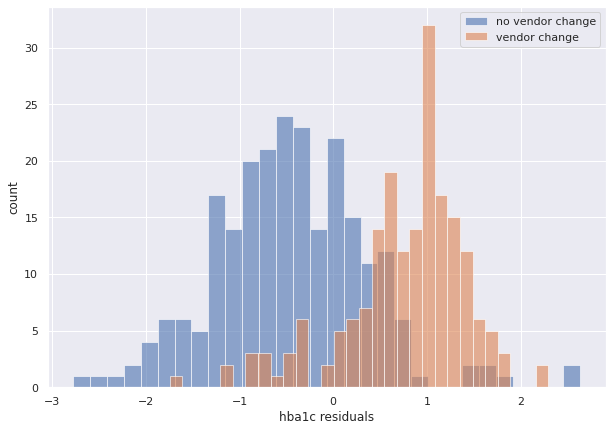

In [53]:
df_no_change = deltas_metabolomics_normalized[deltas_metabolomics_normalized['vendor_change'] == 0]
df_change = deltas_metabolomics_normalized[deltas_metabolomics_normalized['vendor_change'] == 1]


fig = plt.figure(figsize=(10, 7))
plt.hist(df_no_change['hba1c_Residuals'], bins=30, alpha=0.6, label='no vendor change');
plt.hist(df_change['hba1c_Residuals'], bins=30, alpha=0.6, label='vendor change');

plt.xlabel('hba1c residuals');
plt.ylabel('count');
plt.legend();